# Part 1

In [33]:
# function main(args)
#     return args
# end
# Load inline arguments for worker unit
# num_workers, this = main(ARGS)
num_workers = 4 #parse(Int64, num_workers)
this        = 1 #parse(Int64, this)

#
# Important directories
simdir          = "/remote/ceph2/group/gerda/data/mpik/gerda-simulations/gerda-gems-db/pss-dev"
simdir_old      = "/remote/ceph/group/gerda/data/simulation/gerda-mage-sim"
mapping_file    = simdir_old*"/UTILS/det-data/ged-mapping.json"
parameters_file = simdir_old*"/UTILS/det-data/ged-parameters.json"
config_dir      = "/res/Impurity_Scan/config-dep/"

#
# Load packages and functions
include("../src/init.jl")
include("../src/fct.jl")
include("../src/worker_fct.jl")

#
# Output paths and filter settings
plots_base_path = "../../waveforms/sim/plots/raw/"
base_path_raw   = "../../waveforms/sim/raw-test/"
base_path       = "../../waveforms/sim/processed/"
n_sim_events    = 5000
isTP = 0;
isBL = 0;
mult = 1;
sampling_time   = 1u"ns"
hits_threshold  = 0.005; # MeV
E = 400;

In [ ]:
parameters = JSON.parsefile("../dicts/electronics_parameters.json")

In [ ]:
parameters[channel_to_name[24]]["par"]

In [ ]:
#
# Load workers log file
log_file = base_path_raw * "log-" * string(this) * ".json"
if !isdir(base_path_raw)
    mkpath(base_path_raw)
end
if !isfile(log_file)
    open(log_file, "w") do f
        JSON.print(f, Dict(), 4)
    end
    global log = Dict()
else
    global log = JSON.parsefile(log_file)
end;

#
# Collect simulation filepaths
current_dir = pwd()
cd(simdir)
filenames = glob("calib/*/*/*/*.root")
cd(current_dir)

filenames = get_share_for_worker(filenames, num_workers, this)

In [ ]:
data = nothing
for filename in filenames
    E_lim = E
    output_path = base_path_raw*basename(filename)*"/";
    if !haskey(log, basename(filename))
        Base.run(`clear`)
        @info(string(findfirst(x->x == filename, filenames)) * " of " * string(length(filenames)) * " in progress!")
        file = TFile(joinpath(simdir, filename))
        tree = file["fTree"];

        tt = Table(eventnumber = tree.eventnumber[:],
            hits_iddet   = tree.hits_iddet[:],
            hits_edep    = tree.hits_edep[:],
            hits_xpos    = tree.hits_xpos[:] .* 10, # mm
            hits_ypos    = tree.hits_ypos[:] .* 10, # mm
            hits_zpos    = tree.hits_zpos[:] .* 10) # mm

        tt = tt |> @filter(length(_.hits_edep) != 0 && sum(_.hits_edep) >= E_lim/1000 && length(unique(_.hits_iddet)) == 1) |> Table;

        data = Table(
            evtno        = [],
            multiplicity = [],
            detno        = [],
            hits_totnum  = [],
            edep         = [],
            pos          = []
        )
        prog = Progress(size(tt,1), dt=0.5,
            barglyphs=BarGlyphs('|','█', ['▁' ,'▂' ,'▃' ,'▄' ,'▅' ,'▆', '▇'],' ','|',),
            barlen=10)
        for i in eachindex(tt)
            multi = 1
            det = tt[i].hits_iddet[1]
            parameters[sim_to_channel[det][2]]["upside_down"] == true ? upside_down = -1 : upside_down = 1
            append!(data, Table(
                evtno        = [tt[i].eventnumber],
                multiplicity = [multi],
                detno        = [Array{Int64,1}(zeros(length(tt[i].hits_iddet)) .+ sim_to_channel[det][1])],
                hits_totnum  = [length(tt[i].hits_edep)],
                edep         = [tt[i].hits_edep],
                pos          = [[ SVector{3}(([ tt[i].hits_xpos[k] .- parameters[sim_to_channel[det][2]]["detcenter_x"], 
                                        tt[i].hits_ypos[k] .- parameters[sim_to_channel[det][2]]["detcenter_y"], 
                                        upside_down .* (tt[i].hits_zpos[k] .- parameters[sim_to_channel[det][2]]["detcenter_z"] .+ upside_down * parameters[sim_to_channel[det][2]]["height"]/2) 
                            ] * u"mm")...) for k in eachindex(tt[i].hits_xpos) ]]
                )
            )
            next!(prog)
        end
        tt = nothing
        dets = []
        for detno in data.detno
            push!(dets, unique(detno)[1])
        end
        dets = unique(dets)
        prog = Progress(length(dets), dt=0.5,
            barglyphs=BarGlyphs('|','█', ['▁' ,'▂' ,'▃' ,'▄' ,'▅' ,'▆', '▇'],' ','|',),
            barlen=10)
        @info("Creating files for each detector")
        for detno in dets
            det = channel_to_name[detno]
            t = data |> @filter(unique(_.detno)[1] == detno) |> Table;
            !isdir(output_path) ? mkpath(output_path) : ""
            HDF5.h5open(output_path * lpad(detno, 2, "0") * "-" * det * ".h5", "w") do h5f
                LegendHDF5IO.writedata( h5f, "data", Table(
                    evtno       = t.evtno, 
                    event_mult  = t.multiplicity, 
                    detno       = VectorOfArrays(t.detno), 
                    hits_totnum = t.hits_totnum, 
                    edep        = VectorOfArrays(t.edep), 
                    pos         = VectorOfArrays(t.pos)))
            end
            next!(prog)
        end
        
        # Log the progress
        log[basename(filename)] = "Done!"
        open(log_file, "w") do f
            JSON.print(f, log, 4)
        end
    end
end

# Part 2

In [ ]:
# function main(args)
#     return args
# end
# Load inline arguments for worker unit
# num_workers, this = main(ARGS)
num_workers = 3 #parse(Int64, num_workers)
this        = 1 #parse(Int64, this)

#
# Important directories
simdir          = "/remote/ceph2/group/gerda/data/mpik/gerda-simulations/gerda-gems-db/pss-dev"
simdir_old      = "/remote/ceph/group/gerda/data/simulation/gerda-mage-sim"
mapping_file    = simdir_old*"/UTILS/det-data/ged-mapping.json"
parameters_file = simdir_old*"/UTILS/det-data/ged-parameters.json"
config_dir      = "../../../2020-02-06_8380701d_st_ffischer/res/Impurity_Scan/config-dep/"

#
# Load packages and functions
include("../src/init.jl")
include("../src/fct.jl")
include("../src/worker_fct.jl")

#
# Output paths and filter settings
plots_base_path = "../../waveforms/sim/plots/raw/"
base_path_raw   = "../../waveforms/sim/raw/"
base_path       = "../../waveforms/sim/raw_wf/"
n_sim_events    = 10000;
sampling_time   = 1u"ns";
generate_wf     = false;
generate_cl_wf  = true;
no_new_files    = 0

channels = []
for c in 0:1:36
    files = glob(base_path_raw * "raw*/" * lpad(c, 2, "0") * "-" * channel_to_name[c] * ".h5");
    if length(files) > 0
        push!(channels, c)
    end
end
channels = get_share_for_worker(channels, num_workers, this)

In [ ]:
while no_new_files <= 3
    for ch in channels
        @info("Start Ch"*lpad(ch, 2, "0")*" | "*channel_to_name[ch])
        @info(">---------------------------------------------------------------<")
        files = glob(base_path_raw*"*/*-"*channel_to_name[ch]*".h5")

        # Read the SSD simulation file of depleted detector
        config_file = glob(config_dir * channel_to_name[ch] * "*.config")[1]
        sim_output  = glob(config_dir * "../output/"*channel_to_name[ch]*"*/" )[1]
        @info("Load SSD simulation")
        @time sim = @suppress readcreateh5(config_file, sim_output);

        for file in files
            output_dir = base_path * lpad(ch, 2, "0") * "-" * channel_to_name[ch] * "/cl-wf/"
            output_dir *= split(file, "/")[end-1] * "/"
            @time events = h5open(file, "r") do h5f
                LegendHDF5IO.readdata(h5f, "data")
            end;
            last_file = glob(output_dir * "*.h5")
            if length(last_file) == 0
                existance_check = false
            else
                last_file       = last_file[end]
                last_event      = parse(Int64,split(split(last_file,"-")[end], ".h5")[1])
                existance_check = isfile(last_file) && last_event == size(events,1) && stat(last_file).size > 0
            end
            if existance_check
                @info("This file has already been simluated")
            else
                no_new_files = 0
                isdir(output_dir) ? "Directory exists" : output_dir
                file_id = findall(x->x == file, files)[1]
                
                if generate_wf
                    # IJulia.clear_output(true)
                    Base.run(`clear`)
                    @info("File $file_id | " * string(length(files)))
                    @info("Start simulating waveforms for ch" * lpad(ch, 2, "0") * " | " * channel_to_name[ch])
                    @info(">---------------------------------------------------------------<")
                    output_basename  = lpad(ch, 2, "0") * "-" * channel_to_name[ch]*"-wf-"*split(file, "/")[end-1]
                    t_with_waveforms = @suppress SSD.simulate_waveforms(events, sim, output_dir, output_basename, chunk_n_physics_events = n_sim_events, Δt = sampling_time);
                end

                if generate_cl_wf
                    # IJulia.clear_output(true)
                    Base.run(`clear`)
                    @info("File $file_id | "*string(length(files)))
                    @info("Start simulating clustered waveforms for ch" * lpad(ch, 2, "0") * " | " * channel_to_name[ch])
                    @info(">---------------------------------------------------------------<")
                    @info("$(sum(length.(events.edep))) hits before clustering")
                    events_clustered = SSD.cluster_detector_hits(events, 0.2u"mm")
                    @info("$(sum(length.(events_clustered.edep))) hits after clustering")
                    output_basename            = lpad(ch, 2, "0") * "-" * channel_to_name[ch] * "-cl-wf-"*split(file, "/")[end-1]
                    t_clustered_with_waveforms = SSD.simulate_waveforms(events_clustered, sim, output_dir, output_basename, chunk_n_physics_events = n_sim_events, Δt = sampling_time);
                end 
            end
        end
    end
    no_new_files += 1
    sleep(300)
end

# Part 3

In [ ]:
# function main(args)
#     return args
# end
# Load inline arguments for worker unit
# num_workers, this = main(ARGS)
num_workers = 1 #parse(Int64, num_workers)
this        = 1 #parse(Int64, this)

#
# Important directories
simdir          = "/remote/ceph2/group/gerda/data/mpik/gerda-simulations/gerda-gems-db/pss-dev"
simdir_old      = "/remote/ceph/group/gerda/data/simulation/gerda-mage-sim"
mapping_file    = simdir_old*"/UTILS/det-data/ged-mapping.json"
parameters_file = simdir_old*"/UTILS/det-data/ged-parameters.json"
config_dir      = "../../../2020-02-06_8380701d_st_ffischer/res/Impurity_Scan/config-dep/"

#
# Load packages and functions
include("../src/init.jl")
include("../src/fct.jl")
include("../src/worker_fct.jl")

#
# Output paths and filter settings
plots_base_path = "../../waveforms/sim/plots/raw/"
base_path_raw   = "../../waveforms/sim/raw_wf/"
base_path       = "../../waveforms/sim/raw_wf/"
sampling_time   = 1u"ns";
no_new_files    = 0
parameters = JSON.parsefile("../dicts/electronics_parameters.json")

channels = []
for c in 0:1:36
    files = glob(base_path_raw * lpad(c, 2, "0") * "-" * channel_to_name[c] * "/cl-wf/raw*/*.h5");
    if length(files) > 0
        push!(channels, c)
    end
end
channels = get_share_for_worker(channels, num_workers, this);

In [ ]:
for ch in [0]
    Base.run(`clear`)
    @info("Start Ch" * lpad(ch, 2, "0") * " | " * channel_to_name[ch])
    @info(">---------------------------------------------------------------<")

    files = glob(base_path_raw * lpad(ch, 2, "0") * "-" * channel_to_name[ch] * "/cl-wf/raw*/*.h5")
    pro = Progress(length(files), dt=0.5,
        barglyphs=BarGlyphs('|','█', ['▁' ,'▂' ,'▃' ,'▄' ,'▅' ,'▆', '▇'],' ','|',),
        barlen=10)
    for file in files
        file_nr = findall(x->x==file, files)[1]
        filename  = split(file, basename(file))[1]
        filename *= channel_to_name[ch] * "_w_filter" * split(basename(file), channel_to_name[ch])[2]
        filename = split(filename, "/cl-wf/")[1] * "/w_filter/" * split(filename, "/cl-wf/")[2]
        if !isfile(filename)
            data_raw = HDF5.h5open(file, "r") do h5f
                LegendHDF5IO.readdata(h5f, "generated_waveforms")
            end
            first_half = 1:Int(size(data_raw,1) / 2) 
            waveform = add_baseline_and_extend_tail.(data_raw.waveform[first_half], 6000, 12000)

            #
            # Reduce time resolution to fit data
            waveform_w_bl = []
            map(x-> push!(waveform_w_bl, RDWaveform(x.time[1:10:end], x.value[1:10:end])), waveform)
            GBP = parameters[channel_to_name[ch]]["par"]["GBP"]*1e6
            tau = parameters[channel_to_name[ch]]["par"]["tau"]*1e-6
            Cd  = parameters[channel_to_name[ch]]["par"]["Cd"]*1e-12
            Cf  = parameters[channel_to_name[ch]]["par"]["Cf"]*1e-12

            data = Table( 
                energy       = [],
                multiplicity = [],
                timestamp    = [],
                run          = [],
                channel      = [],
                waveform     = []
            )
            for i in eachindex(waveform_w_bl)
                pulse = waveform_w_bl[i].value
                if sum(pulse) > 0
                    filtered_pulse = applyElectronics(pulse; Ts = 10e-9, GBP = GBP, tau = tau, Kv = 150e3, Cd = Cd, Cf = Cf, Rf = 500e6)
                    inter = find_intersect(filtered_pulse, maximum(filtered_pulse)/2, 5)
                    cut   = filtered_pulse[(inter-399):1:(inter+400)]
                    time  = (0:10:7990)u"ns"
                    cut_pulse = RDWaveform(time, cut)
                    append!(data, Table(
                            energy       = [data_raw[i].edep],
                            multiplicity = [data_raw[i].event_mult],
                            timestamp    = [data_raw[i].evtno],
                            run          = [0],
                            channel      = [unique(data_raw[i].detno)[1]],
                            waveform     = [cut_pulse]
                        )
                    )
                end


            end
            events = Table(
                energy       = VectorOfArrays(Array{typeof(data[1].energy),1}(data.energy)),
                multiplicity = Int32.(data.multiplicity),
                timestamp    = Int32.(data.timestamp),
                run          = Int32.(data.run),
                channel      = Int32.(data.channel),
                waveform     = ArrayOfRDWaveforms( Array{typeof(data[1].waveform), 1}(data.waveform) )
            )

            !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
            HDF5.h5open(filename, "w") do h5f
                LegendHDF5IO.writedata(h5f, "data", events)
            end
        end
        next!(pro)
    end
end

# Part 4.1 - get valid range for baseline rms

In [1]:
# function main(args)
#     return args
# end
# Load inline arguments for worker unit
# num_workers, this = main(ARGS)
num_workers = 1 #parse(Int64, num_workers)
this        = 1 #parse(Int64, this)

#
# Load packages and functions
include("../src/init.jl")
include("../src/fct.jl")
include("../src/worker_fct.jl")

function gauss(x, par)
    scale = try par[1] catch; par[1][1] end
    σ     = try par[2] catch; par[2][1] end
    μ     = try par[3] catch; par[3][1] end
    return @. scale * exp(-0.5 * ((x - μ)^2) / (σ^2)) / (sqrt(2 * π * σ^2))
end
#
# Output paths and filter settings
plots_base_path = "../../waveforms/sim/plots/"
base_path_raw   = "../../waveforms/sim/raw_wf/"
base_path       = "../../waveforms/sim/wf/"
plots_bl_path   = "../../waveforms/baselines/plots/"
base_bl_path    = "../../waveforms/baselines/wf/"
base_bl_path_filter = "../../waveforms/baselines/wf_filter/"
sampling_time   = 1u"ns";
parameters = JSON.parsefile("../dicts/electronics_parameters.json")

channels = []
for c in 0:1:36
    files = glob(base_path_raw * lpad(c, 2, "0") * "-" * channel_to_name[c] * "/w_filter/raw*/*.h5");
    if length(files) > 0
        push!(channels, c)
    end
end
channels = get_share_for_worker(channels, num_workers, this);

In [2]:
calib_filepath = "../dicts/calib.json"
calib = JSON.parsefile(calib_filepath);

datasets_str = [
    "0053-0064",
    "0065-0079",
    "0080-0092",
    "0093-0113"
]
det_lib = JSON.parsefile("../dicts/det_lib.json");

┌ Info: Start Ch35 | GD89A
└ @ Main In[9]:8
┌ Info: >---------------------------------------------------------------<
└ @ Main In[9]:9


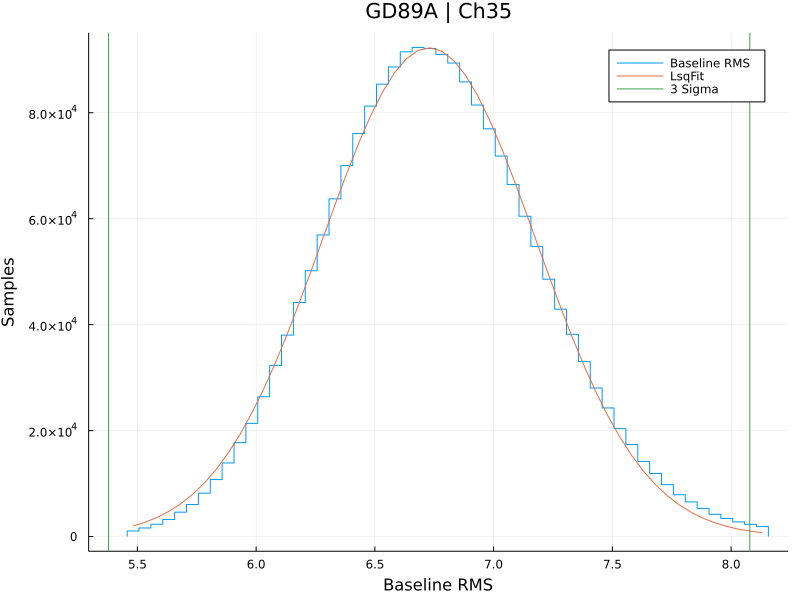

In [9]:

for ch in 5:1:36
    if channel_to_bege[ch] == false || ch in [5,6,7,13]
        continue
    end
    ch_str = lpad(ch, 2, "0")
    IJulia.clear_output(true)
    @info("Start Ch" * ch_str * " | " * channel_to_name[ch])
    @info(">---------------------------------------------------------------<")
    bl_files = glob(base_bl_path * "*/" * ch_str* "-" * channel_to_name[ch] * "/*.h5");
    filtered = []
    for file in bl_files
        run_str = split(basename(file), "-")[2]
        run = parse(Int64, split(run_str, "run")[end])
        ds_str = det_lib[channel_to_name[ch]]["run_str"]
        if run in calib[channel_to_name[ch]]["data"][ds_str]["used_runs"]
            push!(filtered, file)
        end
    end
    bl_files = filtered
    
    if length(bl_files) > 0
        bl_data = Table(run = [], datasetID = [], waveform = [])
        @showprogress 1 "Collecting baselines for Ch $ch ..." for file in bl_files
            tmp_data = HDF5.h5open(file, "r") do h5f
                LegendHDF5IO.readdata(h5f, "data")
            end
            if typeof(tmp_data.run) == Array{Int64,1}
#                 tmp_data = tmp_data |> @filter(_.run >= 80 && _.run <= 92) |> Table
                if size(tmp_data,1) > 0
                    append!(bl_data, Table(run = tmp_data.run, datasetID = tmp_data.datasetID, waveform = tmp_data.waveform))
                end
            else
                println(typeof(tmp_data.run))
            end
        end
        bl_rms = []
        map(x-> 1 < rms(x.value) < 15 ? push!(bl_rms, rms(x.value)) : nothing, bl_data.waveform);
        hist = fit(Histogram, bl_rms, mean(bl_rms)-2*std(bl_rms):0.05:mean(bl_rms)+2*std(bl_rms))

        guess = [
            sum(hist.weights)/10,
            0.2,
            mean(bl_rms)
        ]

        x = Array{Float64, 1}(midpoints(hist.edges[1]))
        y = Array{Float64, 1}(hist.weights)
        y_guess = gauss(x, guess)


        p = plot(x, y, st=:step, label="Baseline RMS")
        p = plot!(x, y_guess)
        #
        #
        #
        #
        f = curve_fit(gauss, x, y, guess)

        y_fit = gauss(x, f.param)

        p = plot(hist, st=:step, label="Baseline RMS")
        p = plot!(x, y_fit, label="LsqFit")
        p = vline!([f.param[3] - 3 * f.param[2], f.param[3] + 3 * f.param[2]], label="3 Sigma")
        p = plot!(size=(800,600), xlabel="Baseline RMS", ylabel="Samples", title=channel_to_name[ch] * " | Ch" * lpad(ch, 2, "0"))
        display(p)
        #
        #
        #
        #
        filename = joinpath(plots_bl_path, "RMS/Ch" * lpad(ch, 2, "0") * "-" * channel_to_name[ch] * ".png")
        savefig(p, filename)
#         return p

        bl_dict_path = "../dicts/bl_rms_limits.json"
        bl_dict = isfile(bl_dict_path) ? JSON.parsefile(bl_dict_path) : Dict()
        !haskey(bl_dict, channel_to_name[ch]) ? bl_dict[channel_to_name[ch]] = Dict() : ""
        bl_dict[channel_to_name[ch]]["low_rms_limit"]  = f.param[3] - 3 * f.param[2]
        bl_dict[channel_to_name[ch]]["high_rms_limit"] = f.param[3] + 3 * f.param[2]
        bl_dict[channel_to_name[ch]]["method"] = "lsqfit"
        bl_dict[channel_to_name[ch]]["fit_params"] = f.param
        bl_dict[channel_to_name[ch]]["fit_params_err"] = margin_error(f)
        bl_dict[channel_to_name[ch]]["bl_num"] = 0
        for bl in bl_rms
            if bl_dict[channel_to_name[ch]]["low_rms_limit"] < bl < bl_dict[channel_to_name[ch]]["high_rms_limit"]
                bl_dict[channel_to_name[ch]]["bl_num"] += 1
            end
        end
        open(bl_dict_path, "w") do f
            JSON.print(f, bl_dict, 4)
        end
    end
end

In [ ]:
### Again -----------------------------------
# 16, 17

In [38]:
# check 12, 14!

In [10]:
bl_dict_path = "../dicts/bl_rms_limits.json"
bl_dict = JSON.parsefile(bl_dict_path);

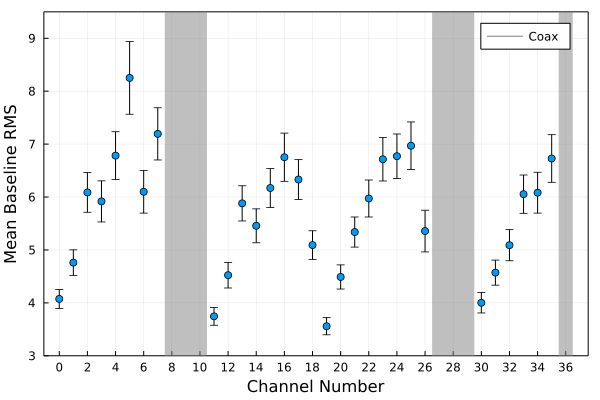

In [12]:
channels = []
m = []
e = []
for ch in 0:1:36
    if channel_to_bege[ch]
        push!(channels, ch)
        push!(m, bl_dict[channel_to_name[ch]]["fit_params"][3])
        push!(e, bl_dict[channel_to_name[ch]]["fit_params"][2])
#         push!(e, bl_dict[channel_to_name[ch]]["fit_params_err"][3])
    end
end
p = scatter(channels, m, err=e, label="")
p = plot!(framestyle=:box, xlabel="Channel Number", ylabel="Mean Baseline RMS", xticks=0:2:36)
p = plot!([7.5,10.5], [2, 2], ribbon=[-10000,5], label="Coax", color=:gray)
p = plot!([26.5,29.5], [2, 2], ribbon=[-10000,5], label="", color=:gray)
p = plot!([35.5,36.5], [2, 2], ribbon=[-10000,5], label="", color=:gray, ylim=(3,9.5))
savefig(p, "mean-baseline-rms.pdf")
p

# Part 4.2 - add baselines to waveforms

In [17]:
# function main(args)
#     return args
# end
# Load inline arguments for worker unit
# num_workers, this = main(ARGS)
num_workers = 1 #parse(Int64, num_workers)
this        = 1 #parse(Int64, this)

#
# Load packages and functions
include("../src/init.jl")
include("../src/fct.jl")
include("../src/worker_fct.jl")

calib_filepath = "../dicts/calib.json"
calib = JSON.parsefile(calib_filepath);

datasets_str = [
    "0053-0064",
    "0065-0079",
    "0080-0092",
    "0093-0113"
]
det_lib = JSON.parsefile("../dicts/det_lib.json");
bl_dict = JSON.parsefile("../dicts/bl_rms_limits.json");
parameters = JSON.parsefile("../dicts/electronics_parameters.json")

#
# Output paths and filter settings
plots_base_path = "../../waveforms/sim/plots/"
base_path_raw   = "../../../2020-02-06_8380701d_st_ffischer/pulses/sim/raw_2vbb/"
base_path       = "../../waveforms/sim/2vbb_check/"
plots_bl_path   = "../../waveforms/baselines/plots/"
base_bl_path    = "../../waveforms/baselines/wf/"

sampling_time   = 1u"ns";

channels = []
for ch in 1:1:36
    if channel_to_bege[ch] == false || ch in [5,6,7,13]
        continue
    end
    push!(channels, ch)
end
channels = get_share_for_worker(channels, num_workers, this);

In [18]:
ch = 0
# for ch in channels

ds_str = det_lib[channel_to_name[ch]]["run_str"]

str_ch = lpad(ch, 2, "0");
@info("Start Ch$str_ch | " * channel_to_name[ch])
@info(">---------------------------------------------------------------<")
@info("Read in baselines")
bl_files = glob(joinpath(base_bl_path, "*/" * str_ch*"-"*channel_to_name[ch]*"/*.h5"))
filtered = []
for file in bl_files
    run = parse(Int64, split(split(basename(file), "-")[2], "run")[end])
    if run in calib[channel_to_name[ch]]["data"][ds_str]["used_runs"]
        push!(filtered, file)
    end
end
bl_files = filtered

bl = Table(run = [], datasetID = [], waveform = [])
@showprogress 1 "Filtering baselines for Ch$str_ch ..." for file in bl_files
    tmp_data = HDF5.h5open(file, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end
    tmp_data = tmp_data |> @filter(bl_dict[channel_to_name[ch]]["low_rms_limit"] < rms(_.waveform.value) < bl_dict[channel_to_name[ch]]["high_rms_limit"]) |> Table
    if size(tmp_data,1) > 0
        append!(bl, Table(run = tmp_data.run, datasetID = tmp_data.datasetID, waveform = tmp_data.waveform))
    end
end

bl = bl |> @filter(bl_dict[channel_to_name[ch]]["low_rms_limit"] < rms(_.waveform.value) < bl_dict[channel_to_name[ch]]["high_rms_limit"]) |> Table
@info("Number of baselines: " * string(size(bl,1)))

┌ Info: Start Ch00 | GD91A
└ @ Main In[18]:7
┌ Info: >---------------------------------------------------------------<
└ @ Main In[18]:8
┌ Info: Read in baselines
└ @ Main In[18]:9
Filtering baselines for Ch00 ...100%|███████████████████| Time: 0:02:24
┌ Info: Number of baselines: 2111121
└ @ Main In[18]:32


In [32]:
@info(">---------------------------------------------------------------<")
files = glob(joinpath(base_path_raw, string(ch) * "-" * channel_to_name[ch] * "/*w_filter-cl-wf*.h5"));
number_of_pulses = 0;
key_str = []
for file in files
    push!(key_str, split(basename(file), "_evts_")[1])
end
key_str = unique(key_str)
for k in key_str
    IJulia.clear_output(true)
    last_file = basename(glob(joinpath(base_path_raw, string(ch) * "-" * channel_to_name[ch] * "/" * string(k) * "*.h5"))[end])
    number_of_pulses += parse(Int64, split(split(split(last_file, "_evts_")[end], "-")[end], ".h5")[1])
end
@info("Found number of simulation pulses: " * string(number_of_pulses))
@info("Found number of noise baselines: " * string(size(bl,1)))
# get first_range
if number_of_pulses <= size(bl,1)
    first_range = [1]
else
    mult_factor = ceil(number_of_pulses/size(bl,1))
    first = 1
    last = 201
    step = Int(round((last-first)/(mult_factor)))
    first_range = first:step:last
end
@info("This results in " * string( size(bl, 1) * length(first_range) ) * " baselines for " * string(number_of_pulses) * " pulses")
@info(">---------------------------------------------------------------<")
@info("Indexing the baselines")
# indices = Table(bl=[], first=[])
# for i in 0:1:number_of_pulses
#     bl_id = i%size(bl,1) + 1
#     first = first_range[Int(ceil((i + 1) / size(bl,1)))]
#     append!(indices, Table(bl=[bl_id], first=[first]))
# end
indices = []
for i in 0:1:(size(bl, 1) * length(first_range)-1)
    bl_id = i%size(bl,1) + 1
    first = first_range[Int(ceil((i+1) / size(bl,1)))]
    push!(indices, [bl_id, first])
end
indices = shuffle(indices)
@info("Add baselines to pulses")

┌ Info: GD91A_w_filter-cl-wf-100_evts_10001-13034.h5
└ @ Main In[32]:12
┌ Info: Found number of simulation pulses: 1303863
└ @ Main In[32]:15
┌ Info: Found number of noise baselines: 2111121
└ @ Main In[32]:16
┌ Info: This results in 2111121 baselines for 1303863 pulses
└ @ Main In[32]:27
┌ Info: >---------------------------------------------------------------<
└ @ Main In[32]:28
┌ Info: Indexing the baselines
└ @ Main In[32]:29
┌ Info: Add baselines to pulses
└ @ Main In[32]:43


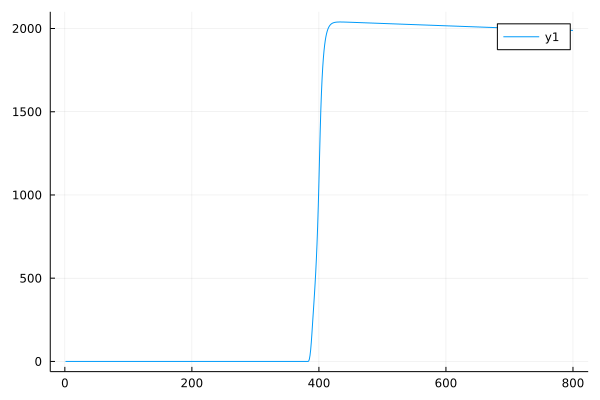

In [11]:
pulse_id = 1
@showprogress "Adding baselines..." for file in files[1:2]
    create_file = false
    ch_str = lpad(ch, 2, "0");
    filename = joinpath(joinpath(base_path, str_ch * "-" * channel_to_name[ch]), basename(file))
    !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
    if isfile(filename)
        if stat(filename).size <= stat(file).size/2
            create_file = true
        end
    else
        create_file = true
    end
    if true#create_file
        data_w_bl = Table(energy=[], multiplicity=[], timestamp=[], run=[], channel=[], waveform=[], evtno=[], pos=[])
        file_no_filter = joinpath(dirname(file), split(basename(file), "w_filter")[1] * "w_bl" * split(basename(file), "w_filter")[end])

        data = HDF5.h5open(file, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end
        data_no_filter = HDF5.h5open(file_no_filter, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end
        
        for i in eachindex(data)
            event = data[i]
            time = event.waveform.time
            pulse = event.waveform.value ./ get_avg_maximum(event.waveform.value, 10)
            pulse .*= sum(event.energy).val #* 1000 # Energy is stored in MeV
            return plot(pulse)

            bl_id = indices[pulse_id][1]
            first = indices[pulse_id][2]

            last = first + length(pulse) - 1
            pulse .+= bl[bl_id].waveform.value[first:1:last]
#             return plot(RDWaveform(time, pulse))
            append!(data_w_bl, Table(energy=[event.energy], 
                                    multiplicity=[event.multiplicity], 
                                    timestamp=[event.timestamp], 
                                    run=[event.run], 
                                    channel=[event.channel], 
                                    waveform=[RDWaveform(time, pulse)],
                                    evtno=[data_no_filter[i].evtno],
                                    pos=[data_no_filter[i].pos])
                );
            pulse_id += 1
        end
        HDF5.h5open(filename, "w") do h5f
            LegendHDF5IO.writedata(h5f, "data", Table(energy     = VectorOfArrays(Array{typeof(data_w_bl[1].energy),1}(data_w_bl.energy)),
                                                    multiplicity = Int32.(data_w_bl.multiplicity),
                                                    timestamp    = Int32.(data_w_bl.timestamp),
                                                    run          = Int32.(data_w_bl.run),
                                                    channel      = Int32.(data_w_bl.channel),
                                                    waveform     = ArrayOfRDWaveforms( Array{typeof(data_w_bl[1].waveform), 1}(data_w_bl.waveform) ),
                                                    evtno        = Int32.(data_w_bl.evtno),
                                                    pos          = VectorOfArrays(Array{typeof(data_w_bl[1].pos), 1}(data_w_bl.pos))))
        end
    else
        pulse_id += size(HDF5.h5open(file, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end, 1)

    end
end

In [113]:
pulse_id

8476766

In [126]:
indices = Table(bl=[], first=[])
for i in 0:1:number_of_pulses
    bl_id = i%size(bl,1) + 1
    first = first_range[Int(ceil((i + 1) / size(bl,1)))]
    append!(indices, Table(bl=[bl_id], first=[first]))
end

# Calc A & E

In [34]:

base_path = "../../waveforms/sim/2vbb_check/"
output_path = "../../waveforms/sim/2vbb_AoE/"
include("../src/fct.jl")
include("../src/fitting-fct.jl")
set = "sim"

calib_filepath = "../dicts/calib.json"
calib = JSON.parsefile(calib_filepath)
cut_lib_filepath = "../dicts/cut_lib.json"
cut_lib = JSON.parsefile(cut_lib_filepath)
AE_cal_filepath = "../dicts/AE_cal.json"
AE_cal = JSON.parsefile(AE_cal_filepath)
sf_lib_filepath = "../dicts/sf_lib.json"
sf_lib = JSON.parsefile(sf_lib_filepath);

In [35]:
for ch in [0]#0:1:36
    if ch in [5,6,7,13] || channel_to_bege[ch] == false
        continue
    end
    ch_str = lpad(ch, 2, "0")

    IJulia.clear_output(true)
    @info("Start with Ch$ch_str")


    files = glob(joinpath(base_path, ch_str * "-" * channel_to_name[ch] * "/*.h5"));
    
    numofele = 5
    BackDelta5 = div(numofele,2)
    ForwardDelta5 = isodd(numofele) ? div(numofele,2) : div(numofele,2) - 1
    numofele = 201
    BackDelta201 = div(numofele,2)
    ForwardDelta201 = isodd(numofele) ? div(numofele,2) : div(numofele,2) - 1
    
    data = Table(A=[], E=[], E_unsmeared=[], energy=[], evtno=[], pos=[])

    @showprogress "Calculating A & E " for file in files
        tmp = HDF5.h5open(file, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end

        A = []
        E = []
        for wf in tmp.waveform
            push!(A, maximum(movingaverage(diff(wf.value),5,BackDelta5,ForwardDelta5,3)))
            push!(E, maximum(movingaverage(diff(wf.value),201,BackDelta201,ForwardDelta201,13)))
        end
        E_cal = linmodel(E, calib[channel_to_name[ch]][set]["lin_cal"][1])
        energy = []
        for e in sum.(tmp.energy)
            push!(energy, e.val)
        end
        append!(data, Table(A=A, E=E, E_unsmeared=E_cal, energy=energy, evtno=tmp.evtno, pos=tmp.pos))
    end

    smearing_dict = JSON.parsefile("../dicts/smearing.json")["Gauss"]
    p0 = [smearing_dict[string(ch)]["params"]["0"], smearing_dict[string(ch)]["params"]["1"], smearing_dict[string(ch)]["params"]["2"]]
    E = []
    @showprogress "Smearing energy " for e in data.E_unsmeared
        d = Normal(0, sqrt_fct(e,p0))
        push!(E, e + rand(d))
    end
    AoE = data.A ./ E
    AoE ./= calib[channel_to_name[ch]][set]["AE_norm"]
    AoE ./= linmodel(E, AE_cal[channel_to_name[ch]][set]["lin_fit"])
    AoE ./= AE_cal[channel_to_name[ch]][set]["DEP_fit"][1]["μ"]
    AoE .-= 1
    AoE ./= hypmodel(E, AE_cal[channel_to_name[ch]][set]["sig_fit"])
    
    filename = joinpath(output_path, ch_str * "-" * channel_to_name[ch] * "-AE_smeared.h5")
    !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
    HDF5.h5open(filename, "w") do h5f
        LegendHDF5IO.writedata(h5f, "data", Table(A = Array{Float64,1}(data.A), 
                                                E = Array{Float64,1}(E),
                                                AoE = Array{Float64,1}(AoE),
                                                E_unsmeared = Array{Float64,1}(data.E_unsmeared),
                                                energy = Array{Float64,1}(data.energy),
                                                evtno = Array{Int64}(data.evtno),
                                                pos = VectorOfArrays(Array{typeof(data.pos[1])}(data.pos))
            )
        )
    end
end

┌ Info: Start with Ch00
└ @ Main In[35]:8
Calculating A & E 100%|█████████████████████████████████| Time: 3:39:38
Smearing energy 100%|███████████████████████████████████| Time: 0:00:04
